In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# import helper functions from utils.py:
from utils import tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, train_parameters, evaluation, get_run_prefix, show_and_save_results,get_test_log_likelihood

In [2]:
disasters_array = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                   3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                   2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                   1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                   0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                   3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [5]:
data_samples = np.array([])
tmp = [(i+np.linspace(0,1,disasters_array[i]+2)[1:-1]) for i in np.arange(disasters_array.shape[0])]

for j in np.arange(len(tmp)):
    data_samples = np.append(data_samples, tmp[j])

rand_idx = np.random.randint(2,size=data_samples.shape[0])

test_samples = data_samples[rand_idx == 1]
train_samples = data_samples[rand_idx == 0]

In [6]:
optimize_inducing_points = False
train_hyperparameters    = True
max_iterations           = 100
learning_rate            = 0.001
gamma_init               = 1.
alphas_init              = 100.
ind_point_number         = 10

log_dir    =  'logs/coal_mining'
run_prefix = get_run_prefix(optimize_inducing_points, train_hyperparameters, ind_point_number, max_iterations, learning_rate, gamma_init, alphas_init)

Tlims = np.array([[0, 120]])
m_val, S_val, Kzz_inv, alphas_vals, Z_pos, gamma_val = train_parameters(np.expand_dims(train_samples,1), 
                                                           ind_point_number         = ind_point_number, 
                                                           Tlims                    = Tlims, 
                                                           optimize_inducing_points = optimize_inducing_points, 
                                                           train_hyperparameters    = train_hyperparameters, 
                                                           learning_rate            = learning_rate, 
                                                           max_iterations           = max_iterations, 
                                                           gamma_init               = gamma_init, 
                                                           alphas_init              = alphas_init, 
                                                           log_dir                  = log_dir, 
                                                           run_prefix               = run_prefix)

Begin training
Fixed inducing points on a grid
Z.shape: (10, 1)


Numeric results:
kernel hyperparameters:
-> alphas = [ 100.01541901]
-> gamma  = 0.34398454427719116


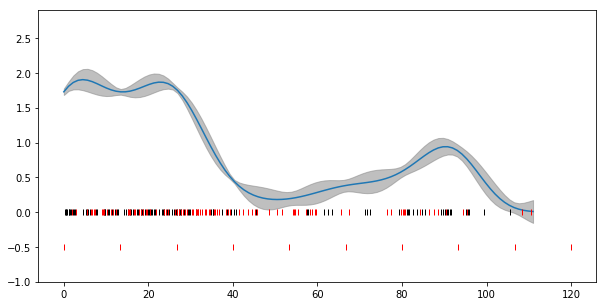

In [7]:
eval_points = np.expand_dims(np.linspace(0, 111, 100), axis=1)
lam_vals, lam_var_vals  = evaluation(m_val, S_val, Kzz_inv, alphas_vals, gamma_val, Z_pos, eval_points)

show_and_save_results(alphas_init,
                      gamma_init,
                      ind_point_number,
                      learning_rate,
                      max_iterations,
                      m_val, 
                      S_val, 
                      alphas_vals, 
                      gamma_val, 
                      Z_pos,
                      eval_points, 
                      lam_vals,
                      lam_var_vals,
                      log_dir + '/' + run_prefix + '/',
                      train_samples=train_samples,
                      test_samples=test_samples
                     )

In [8]:
def get_lower_test_bound(test_samples, m, S, Kzz_inv, a, g, Z):
    lower_bound, Z_ph, X_test_ph, m_ph, S_ph,K_zz_inv_ph,a_ph,g_ph  = get_test_log_likelihood()

    #run session
    with tf.Session() as sess:
        lower_bound_val, = sess.run([lower_bound], feed_dict={Z_ph:Z, X_test_ph:test_samples,K_zz_inv_ph: Kzz_inv,S_ph:S,m_ph:m,a_ph:a,g_ph:g})

    return lower_bound_val

[[-116.58045959]]


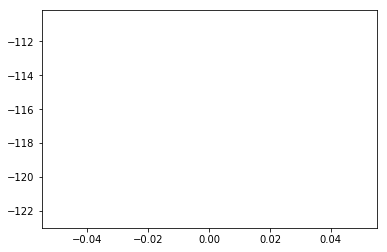

In [12]:
lower_bound_vals = get_lower_test_bound(np.expand_dims(test_samples,1),m_val,S_val,Kzz_inv,alphas_vals,  gamma_val,Z_pos)
plt.plot(lower_bound_vals)
print(lower_bound_vals)